### Forecast experiment 3 - Electricity production data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

# in time series forecasting, we usually need to scale our values
# for better end results
from sklearn.preprocessing import MinMaxScaler

In [2]:
# let's try a pandas DataFrame instead
df = pd.read_csv("cleaned_weather.csv")

In [3]:
df

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,...,1234.61,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,...,1235.20,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,...,1235.82,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,...,1235.49,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47


In [4]:
df['date'] = pd.to_datetime(df['date'])

<Axes: >

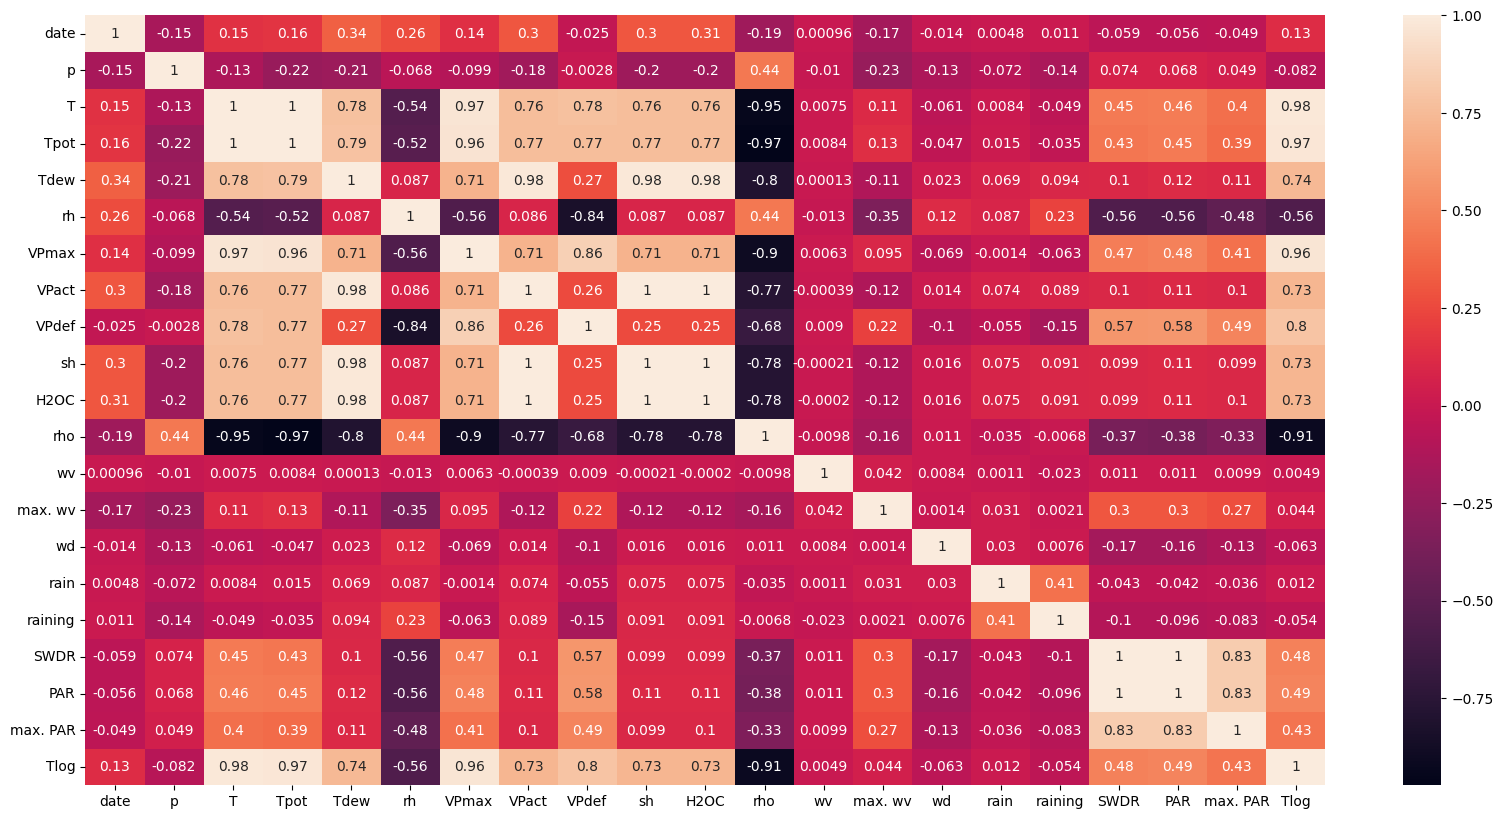

In [5]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

In [6]:
data = df[["date", "T"]]

In [7]:
data

,date,T
0,2020-01-01 00:10:00,0.71
1,2020-01-01 00:20:00,0.75
2,2020-01-01 00:30:00,0.73
3,2020-01-01 00:40:00,0.37
4,2020-01-01 00:50:00,0.33
...,...,...
52691,2020-12-31 23:20:00,2.28
52692,2020-12-31 23:30:00,2.13
52693,2020-12-31 23:40:00,1.99
52694,2020-12-31 23:50:00,2.07


**Before going any further, scale the values in our DataFrame**

In [8]:
# scale the values with MinMaxScaler so that we don't
# affect the distribution of data (thus making the signal not realistic anymore)
# MinMaxScaler is a good solution here
scaler = MinMaxScaler()
data[["T"]] = scaler.fit_transform(data[["T"]])


# as weird as it sounds, scaling the index/sequence number also
# to be a decimal might affect the performance of the network
data = data.drop("date", axis=1)
data.index = data.index * 0.1 + 1

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_15752\4064498883.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["T"]] = scaler.fit_transform(data[["T"]])


In [9]:
data

,T
1.0,0.173375
1.1,0.174345
1.2,0.173860
1.3,0.165131
1.4,0.164161
...,...
5270.1,0.211445
5270.2,0.207808
5270.3,0.204413
5270.4,0.206353


In [10]:
# let's figure out a good cutoff point for train/test
# 67% for training, 25% testing (NOTE: you should experiment on this to find optimal %)
cutoff = int(len(data) * 0.8)

# train data
X_train = data.index[0:cutoff]
y_train = data["T"].iloc[0:cutoff]

# test data
X_test = data.index[cutoff:]
y_test = data["T"].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# in this case, number of variables is 1 => scaled passengers value
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))


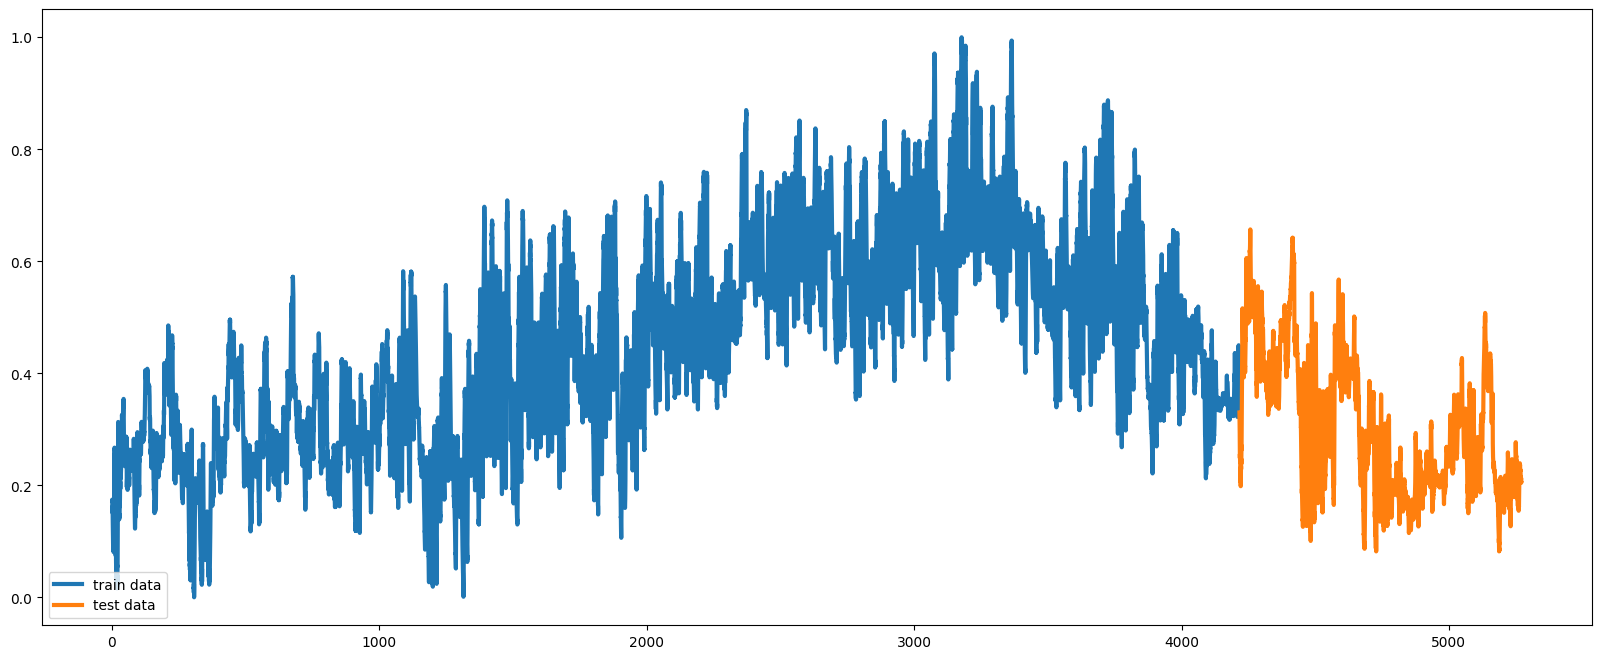

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [12]:
from tensorflow.keras.utils import timeseries_dataset_from_array

# the variable that determines how many points
# back into the past the model attempts to learn
look_back  = 24
batch_size = 256
window_size = 1

# stride = 1 => means we use separate time steps
# more than 1 => we use windowing

# THIS IS USING THE MORE MODERN TENSORFLOW DATASETS
# INSTEAD OF THE ORIGINAL TIMESERIES GENERATORS
# TimeseriesGenerator is deprecated and will be removed in future
# Tensorflow versions, but nobody knows exactly when that happens

# unfortunately, the TF datasets and the original TimeseriesGenerators
# do the same thing in THEORY, but in practice, they function in a different
# manner when feeding the training data into the neural network while training

train_generator = timeseries_dataset_from_array(
    data=train_series,
    targets=train_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = timeseries_dataset_from_array(
    data=test_series,
    targets=test_series[look_back:],
    sequence_length=look_back,
    sampling_rate=1,
    sequence_stride=window_size,
    batch_size=batch_size,
    shuffle=False,
)


In [13]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_cleaned_weather.keras', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(
    monitor='val_loss',     
    patience=10,             
    restore_best_weights=True  
)
callback_list = [mc,es]

# build the neural network
# in this case, LSTM with 8 neurons
n_neurons  = 128

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, activation="relu"))

# alternatively, we might try adding regularization here as well
# so add to the Dense-layer => kernel_regularizer=keras.regularizers.l1(l1=0.1)
# might need some experimentation, whether L1, L2 or L1/L2 is the best one
# and if you need to increase the regularization rate to be above 0.1
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))

# due to the differences how TF datasets and Timeseries Generators 
# actually work and feed the data to the neural network
# you usually need to increase regularization when switching to TF datasets
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# it's not optimal to use test data as validation data
# because this might skew our metrics
# see the other version of this notebook on how to do
# train/validation/test -split for the sine wave
model.fit(train_generator, epochs=150, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0168 - val_loss: 0.0014
Epoch 2/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0043 - val_loss: 2.7807e-04
Epoch 3/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0031 - val_loss: 3.1844e-04
Epoch 4/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0026 - val_loss: 2.9957e-04
Epoch 5/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0024 - val_loss: 4.8914e-04
Epoch 6/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0023 - val_loss: 5.5819e-04
Epoch 7/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 9/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0021 - val_loss: 8.8706e-04
Epoch 10/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 11/150
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0024 - val_loss: 8.

**Training metrics**

<Axes: >

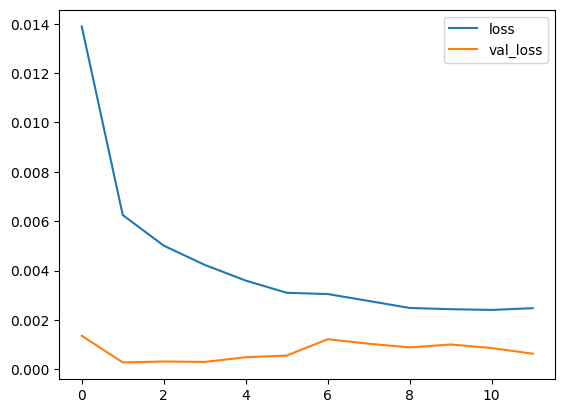

In [14]:
# the usual training metrics visualization
loss_data = pd.DataFrame(model.history.history)
loss_data.plot()

In [15]:
# reload the best version of the model
from keras.models import load_model
model = load_model("best_model_cleaned_weather.keras")

In [16]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close to each other, 
# which means our model is quite optimal
# IN THEORY 

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 6.3487e-04
Training loss: 0.0008083089487627149
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.9981e-04
Testing loss: 0.0002780729264486581


**Test predictions**

In [17]:
test_predictions  = model.predict(test_generator)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


**Conventional regression metrics + MAPE**

In [18]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
5.29 %

MAE
0.01 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.98


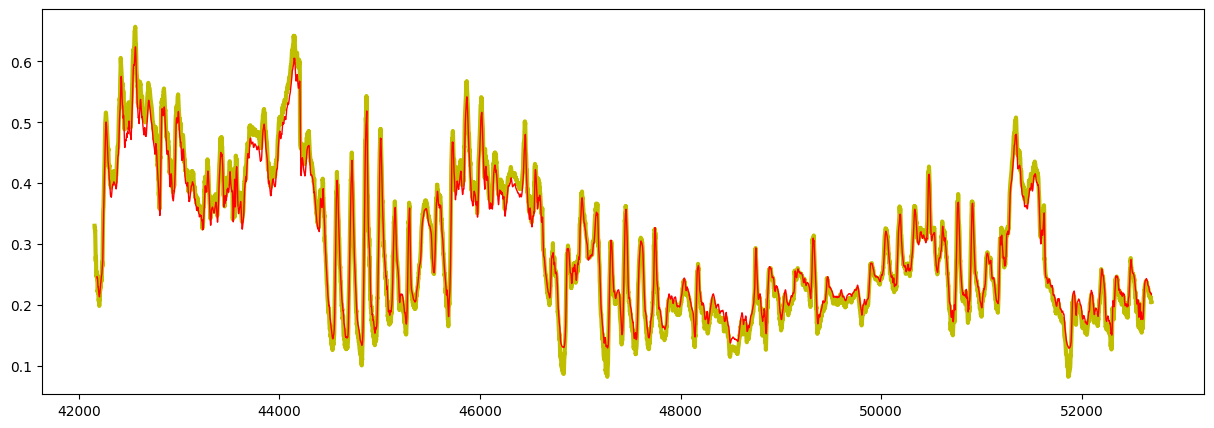

In [19]:
# calculate helper x-variables for where the train data starts
# where the test data starts and where the predictions start
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [20]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 6.3487e-04
Training loss: 0.0008083089487627149
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.9981e-04
Testing loss: 0.0002780729264486581


**Extrapolation into the future**

In [21]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

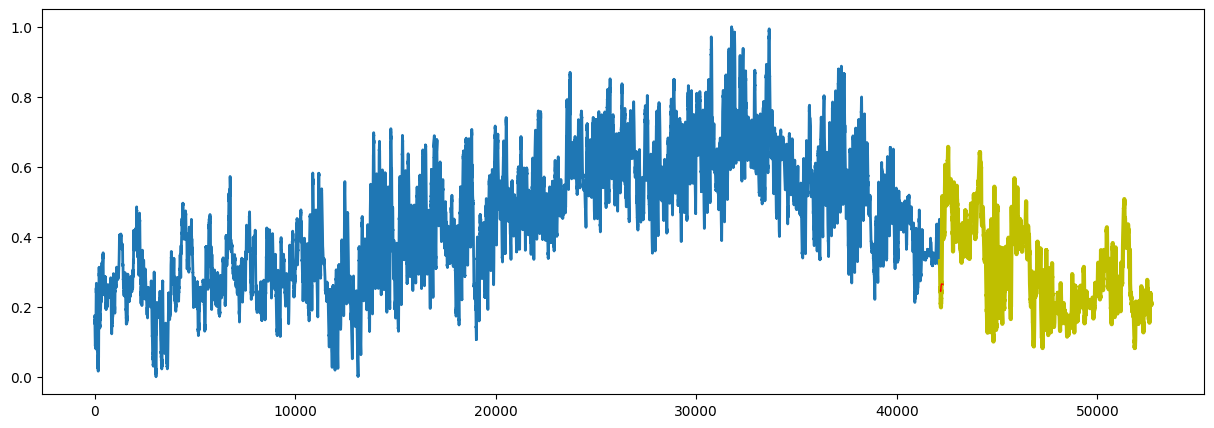

In [22]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()